# Face Recognition

---


**Team Calculator Phone**  
Nathan Diekema & Hannah Chookaszian


In [ ]:

!pip install tensorflow==2.13.0-rc2
!pip install tensorflow_addons
!pip install keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.0
    Uninstalling tensorflow-2.13.0:
      Successfully uninstalled tensorflow-2.13.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.3 MB/s eta 0:00:00


In [ ]:
import keras
import dlib
import numpy as np
import cv2 as cv
import tensorflow as tf
import tensorflow_addons as tfa
# from openface.align import AlignDlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split  #Use for splitting training/validation datasets
from tensorflow.keras.utils import to_categorical                #For one-hot encoding of data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
np.random.seed(1234)
tf.random.set_seed(1234)

**Create a HOG face detector**   
Might UPDATE later with better face detector

**Import LFW dataset**

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=200, slice_ = (slice(61,189),slice(61,189)),resize=0.5, color=False) #reshape images to 64x64
n_samples, h, w = faces.images.shape[:3]
n_classes = faces.target_names.shape[0]
x_train = np.reshape(faces.images,(-1,64,64,1))
y_train = faces.target

**Image Normalization**

In [ ]:
print("x shape:", x_train.shape)
print("y shape:", y_train.shape)

x_train = x_train.astype('float32') / 255

#Center Images
training_mean = np.mean(x_train).astype(np.float32)
print(training_mean)
x_train -= training_mean

x shape: (766, 64, 64, 1)
y shape: (766,)
0.0018728176


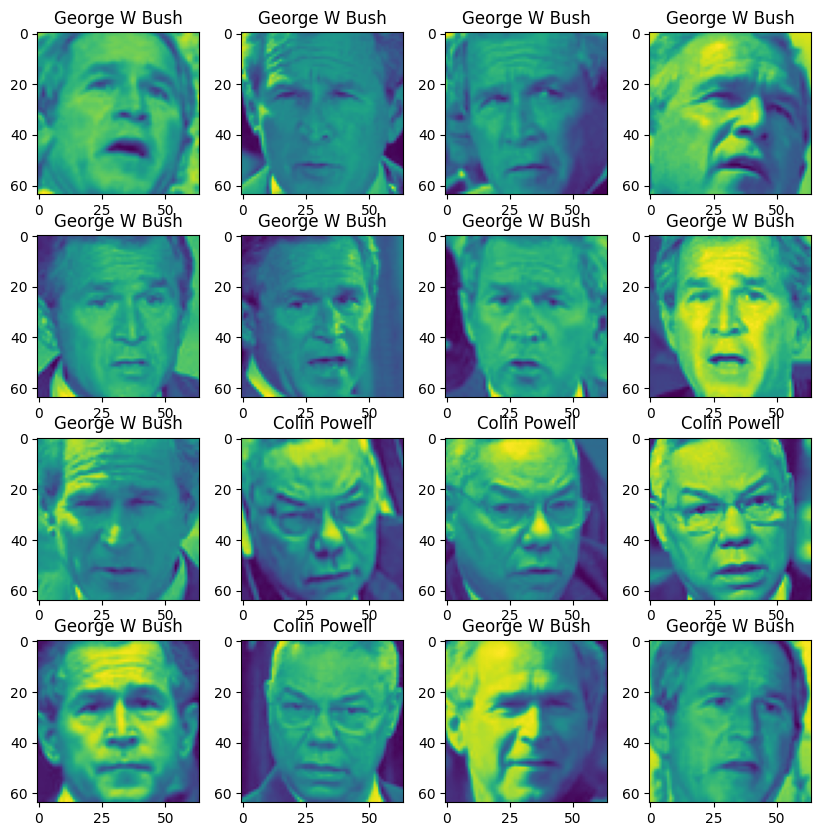

In [ ]:
fig, axs = plt.subplots(4,4,gridspec_kw={'hspace':0.25, 'wspace':0.25}, figsize=(10,10))
i=0
for row in axs:
  for col in row:
    col.imshow(np.squeeze(x_train[i]))
    col.set_title(faces.target_names[y_train[i]])
    i+=1

**Split into: Training, Testing and Validation**



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, random_state=42,stratify=y_train) #Training & testing sets
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=42,stratify=y_test) #Validation set
print("Training Size: ", len(y_train))
print("Validation Size: ", len(y_val))
print("Testing Size: ", len(y_test))

Training Size:  612
Validation Size:  77
Testing Size:  77


In [ ]:
print(x_train.shape)
print(x_train.shape[1:])

(612, 64, 64, 1)
(64, 64, 1)


# CNN Design & Training
We tried and compared two different types of loss functions: Softmax and TripletLoss

In [ ]:
#@title Training Settings
Train_normal_flag = True #@param {type:"boolean"}
Train_triplet_flag = True #@param {type:"boolean"}

print(Train_normal_flag)
print(Train_triplet_flag)

True
True




---


**Normal 'Softmax' Method**


---



In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

In [ ]:
# Input size is 64x64
x_in = Input(x_train.shape[1:])
chanDim = -1

# Layer 1
x = Conv2D(32,5,padding='same',activation='relu')(x_in)  #32 filters
x = Conv2D(32,5,padding='same',activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(axis=chanDim)(x)  #helps mitigate overfitting
x = Dropout(0.25)(x)

#Layer 2
x = Conv2D(64,3,padding='same',activation='relu')(x)  #64 filters
x = Conv2D(64,3,padding='same',activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.25)(x)

#Layer 3
x = Conv2D(64,3,padding='same',activation='relu')(x)
x = Conv2D(64,3,padding='same',activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.25)(x)

# Layer 4
x = Conv2D(128,3,padding='same',activation='relu')(x) #128 filters
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.25)(x)

# Flatten to a vector
x = Flatten()(x)

# Dense (fully-connected) layer
x = Dense(512)(x)
x = Activation('relu')(x)
x = BatchNormalization(axis=chanDim)(x)
x = Dropout(0.4)(x)

# Output layer
x = Dense(n_classes)(x) #ensure probabilities sum to 1.0
x = Activation('softmax')(x)

model = Model(inputs=x_in,outputs=x)
model.summary()
# plot_model(model, to_file='softmax_model.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0     

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.optimizers.Adam(lr=1e-4),metrics=['sparse_categorical_accuracy'])

**Training**

In [ ]:
if Train_normal_flag:
  history = model.fit(x_train, y_train, shuffle=True, epochs=200, batch_size=128, validation_data=(x_val, y_val)) #use 10% of training dataset for validation
else:
  pass

Epoch 1/200
5/5 [==============================] - 21s 599ms/step - loss: 1.1112 - sparse_categorical_accuracy: 0.5964 - val_loss: 0.6859 - val_sparse_categorical_accuracy: 0.6883
Epoch 2/200
5/5 [==============================] - 0s 65ms/step - loss: 0.8453 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.7299 - val_sparse_categorical_accuracy: 0.3117
Epoch 3/200
5/5 [==============================] - 0s 64ms/step - loss: 0.6750 - sparse_categorical_accuracy: 0.7582 - val_loss: 0.7254 - val_sparse_categorical_accuracy: 0.3117
Epoch 4/200
5/5 [==============================] - 0s 64ms/step - loss: 0.5991 - sparse_categorical_accuracy: 0.7925 - val_loss: 0.6826 - val_sparse_categorical_accuracy: 0.6883
Epoch 5/200
5/5 [==============================] - 0s 63ms/step - loss: 0.4760 - sparse_categorical_accuracy: 0.8317 - val_loss: 0.8288 - val_sparse_categorical_accuracy: 0.3117
Epoch 6/200
5/5 [==============================] - 0s 62ms/step - loss: 0.4549 - sparse_categorical_accuracy

**Results**


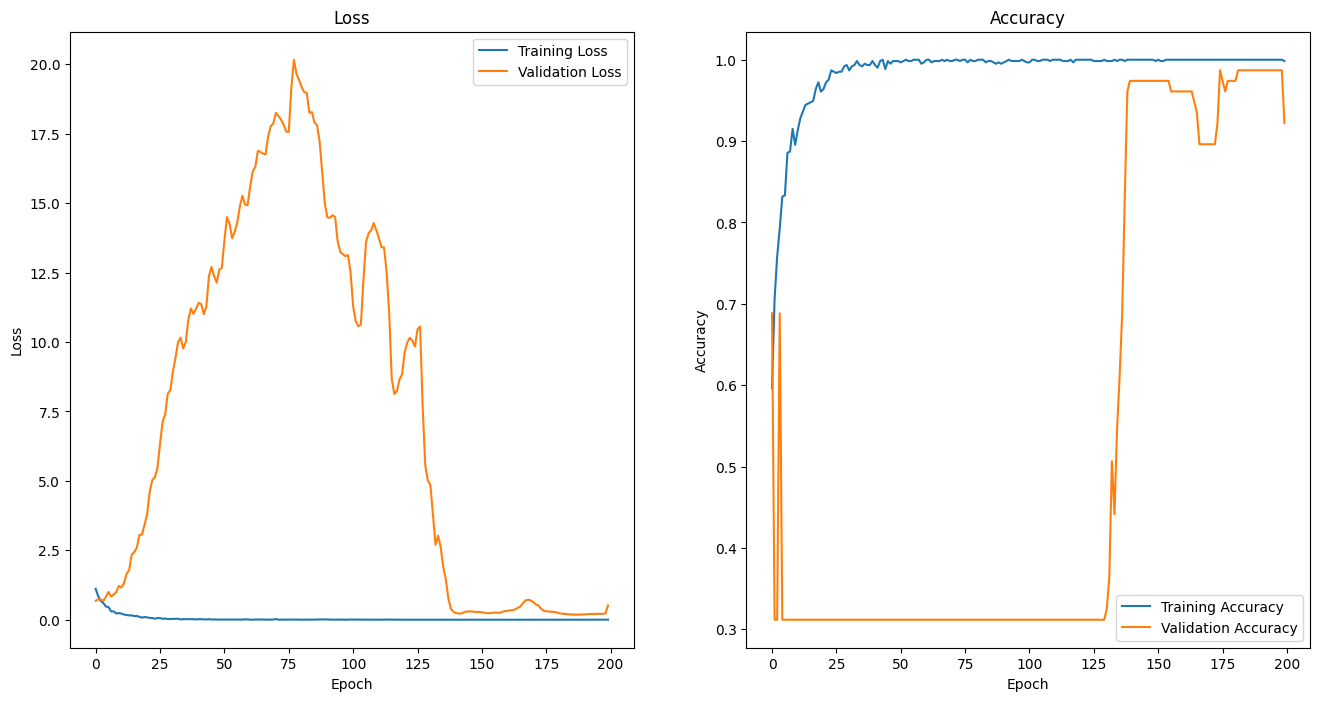

In [ ]:
if Train_normal_flag:
  fig, axs = plt.subplots(1,2,figsize=(16,8))
  axs[0].plot(history.history['loss'])
  axs[0].plot(history.history['val_loss'])
  axs[0].legend(['Training Loss','Validation Loss'])
  axs[0].set_title('Loss')
  axs[0].set(xlabel='Epoch', ylabel='Loss')

  axs[1].plot(history.history['sparse_categorical_accuracy'])
  axs[1].plot(history.history['val_sparse_categorical_accuracy'])
  axs[1].legend(['Training Accuracy','Validation Accuracy'])
  axs[1].set_title('Accuracy')
  axs[1].set(xlabel='Epoch', ylabel='Accuracy')


**Testing Accuracy**

In [ ]:
if Train_normal_flag:
  results = model.evaluate(x_train,y_train,verbose=0)
  print('Training Accuracy: %.2f %%'%(results[1]*100))
  results = model.evaluate(x_test,y_test,verbose=0)
  print('Testing Accuracy: %.2f %%'%(results[1]*100))

Training Accuracy: 95.59 %
Testing Accuracy: 90.91 %


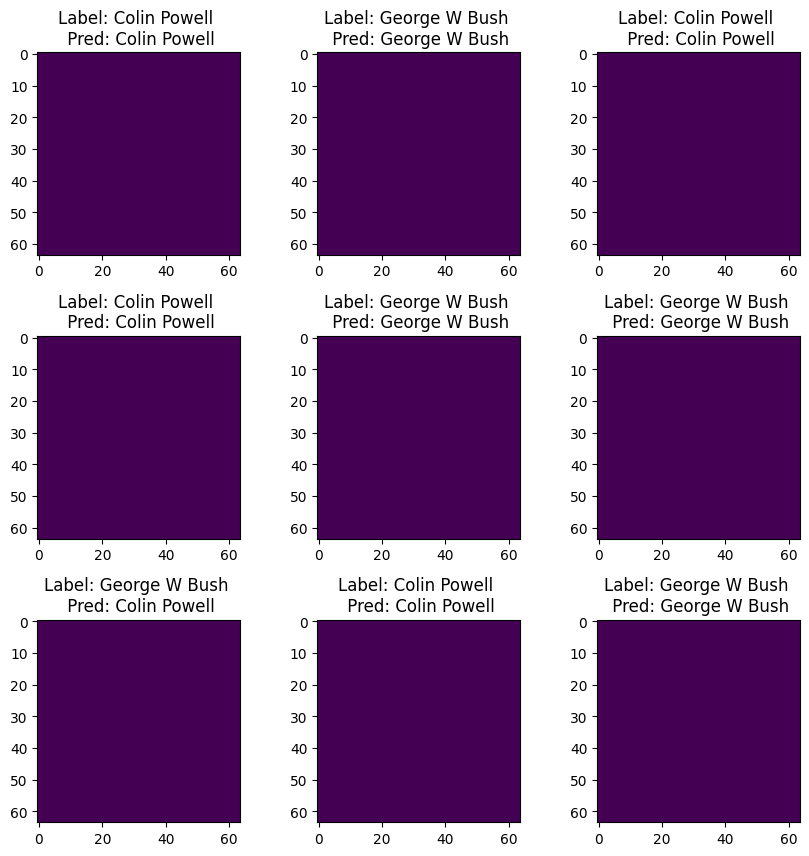

In [ ]:
if Train_normal_flag:
  preds = model.predict(x_test,verbose=0)
  im,label,pred = x_test,y_test,preds
  names = faces.target_names

  fig, axs = plt.subplots(3,3,gridspec_kw={'hspace':0.4, 'wspace':0.3}, figsize=(10,10))
  i=0
  for row in axs:
    for col in row:
      predlabel = np.argmax(pred[i])
      imout = ((np.squeeze(im[i])+training_mean)*255).astype('uint8')
      col.imshow(imout)
      col.set_title('Label: %s \n Pred: %s'%(names[label[i]],names[predlabel]))
      i+=1



---


**Triplet Loss Method**

---



In [ ]:
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.framework import dtypes

def pairwise_distance(feature, squared=False):
  """Computes the pairwise distance matrix with numerical stability.

  output[i, j] = || feature[i, :] - feature[j, :] ||_2

  Args:
    feature: 2-D Tensor of size [number of data, feature dimension].
    squared: Boolean, whether or not to square the pairwise distances.

  Returns:
    pairwise_distances: 2-D Tensor of size [number of data, number of data].
  """
  pairwise_distances_squared = math_ops.add(
      math_ops.reduce_sum(math_ops.square(feature), axis=[1], keepdims=True),
      math_ops.reduce_sum(
          math_ops.square(array_ops.transpose(feature)),
          axis=[0],
          keepdims=True)) - 2.0 * math_ops.matmul(feature,
                                                  array_ops.transpose(feature))

  # Deal with numerical inaccuracies. Set small negatives to zero.
  pairwise_distances_squared = math_ops.maximum(pairwise_distances_squared, 0.0)
  # Get the mask where the zero distances are at.
  error_mask = math_ops.less_equal(pairwise_distances_squared, 0.0)

  # Optionally take the sqrt.
  if squared:
      pairwise_distances = pairwise_distances_squared
  else:
      pairwise_distances = math_ops.sqrt(
          pairwise_distances_squared + tf.cast(error_mask, dtype='float32') * 1e-16)

  # Undo conditionally adding 1e-16.
  pairwise_distances = math_ops.multiply(
      pairwise_distances, tf.cast(math_ops.logical_not(error_mask),dtype='float32'))

  num_data = array_ops.shape(feature)[0]
  # Explicitly set diagonals to zero.
  mask_offdiagonals = array_ops.ones_like(pairwise_distances) - array_ops.diag(
      array_ops.ones([num_data]))
  pairwise_distances = math_ops.multiply(pairwise_distances, mask_offdiagonals)
  return pairwise_distances

def masked_maximum(data, mask, dim=1):
  """Computes the axis wise maximum over chosen elements.

  Args:
    data: 2-D float `Tensor` of size [n, m].
    mask: 2-D Boolean `Tensor` of size [n, m].
    dim: The dimension over which to compute the maximum.

  Returns:
    masked_maximums: N-D `Tensor`.
      The maximized dimension is of size 1 after the operation.
  """
  axis_minimums = math_ops.reduce_min(data, dim, keepdims=True)
  masked_maximums = math_ops.reduce_max(
      math_ops.multiply(data - axis_minimums, mask), dim,
      keepdims=True) + axis_minimums
  return masked_maximums

def masked_minimum(data, mask, dim=1):
  """Computes the axis wise minimum over chosen elements.

  Args:
    data: 2-D float `Tensor` of size [n, m].
    mask: 2-D Boolean `Tensor` of size [n, m].
    dim: The dimension over which to compute the minimum.

  Returns:
    masked_minimums: N-D `Tensor`.
      The minimized dimension is of size 1 after the operation.
  """
  axis_maximums = math_ops.reduce_max(data, dim, keepdims=True)
  masked_minimums = math_ops.reduce_min(
      math_ops.multiply(data - axis_maximums, mask), dim,
      keepdims=True) + axis_maximums
  return masked_minimums

In [ ]:
def triplet_loss_adapted_from_tf(y_true, y_pred):
  del y_true
  margin = 1.
  labels = y_pred[:, :1]

  labels = tf.cast(labels, dtype='int32')

  embeddings = y_pred[:, 1:]

  ### Code from Tensorflow function [tf.contrib.losses.metric_learning.triplet_semihard_loss] starts here:

  # Build pairwise squared distance matrix.
  pdist_matrix = pairwise_distance(embeddings, squared=True)
  # Build pairwise binary adjacency matrix.
  adjacency = math_ops.equal(labels, array_ops.transpose(labels))
  # Invert so we can select negatives only.
  adjacency_not = math_ops.logical_not(adjacency)

  # global batch_size
  batch_size = array_ops.size(labels) # was 'array_ops.size(labels)'

  # Compute the mask.
  pdist_matrix_tile = array_ops.tile(pdist_matrix, [batch_size, 1])
  mask = math_ops.logical_and(
      array_ops.tile(adjacency_not, [batch_size, 1]),
      math_ops.greater(
          pdist_matrix_tile, array_ops.reshape(
              array_ops.transpose(pdist_matrix), [-1, 1])))
  mask_final = array_ops.reshape(
      math_ops.greater(
          math_ops.reduce_sum(
              math_ops.cast(mask, dtype=dtypes.float32), 1, keepdims=True),
          0.0), [batch_size, batch_size])
  mask_final = array_ops.transpose(mask_final)

  adjacency_not = math_ops.cast(adjacency_not, dtype=dtypes.float32)
  mask = math_ops.cast(mask, dtype=dtypes.float32)

  # negatives_outside: smallest D_an where D_an > D_ap.
  negatives_outside = array_ops.reshape(
      masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size])
  negatives_outside = array_ops.transpose(negatives_outside)

  # negatives_inside: largest D_an.
  negatives_inside = array_ops.tile(
      masked_maximum(pdist_matrix, adjacency_not), [1, batch_size])
  semi_hard_negatives = array_ops.where(
      mask_final, negatives_outside, negatives_inside)

  loss_mat = math_ops.add(margin, pdist_matrix - semi_hard_negatives)

  mask_positives = math_ops.cast(
      adjacency, dtype=dtypes.float32) - array_ops.diag(
      array_ops.ones([batch_size]))

  # In lifted-struct, the authors multiply 0.5 for upper triangular
  #   in semihard, they take all positive pairs except the diagonal.
  num_positives = math_ops.reduce_sum(mask_positives)

  semi_hard_triplet_loss_distance = math_ops.truediv(
      math_ops.reduce_sum(
          math_ops.maximum(
              math_ops.multiply(loss_mat, mask_positives), 0.0)),
      num_positives,
      name='triplet_semihard_loss')

  ### Code from Tensorflow function semi-hard triplet loss ENDS here.
  return semi_hard_triplet_loss_distance

**Create a base network**

In [ ]:
def create_base_model(input_shape,embedding_size):

  # Input size is 64x64
  x_in = Input(shape=input_shape)

  # Layer 1
  x = Conv2D(32,5,padding='same',activation='relu')(x_in)
  x = Conv2D(32,3,padding='same',activation='relu')(x)
  x = MaxPooling2D(2,2)(x)

  # Layer 2
  x = Conv2D(64,3,padding='same',activation='relu')(x)
  x = MaxPooling2D(2,2)(x)
  x = Dropout(0.1)(x)

  # Layer 3
  x = Conv2D(64,3,padding='same',activation='relu')(x)
  x = MaxPooling2D(2,2)(x)
  x = Dropout(0.2)(x)

  # Layer 4
  x = Conv2D(128,3,padding='same',activation='relu')(x)
  x = MaxPooling2D(2,2)(x)
  x = Dropout(0.2)(x)

  # Flatten to a vector
  x = Flatten()(x)
  x = Dense(512,activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(256,activation='relu')(x)
  x = Dropout(0.2)(x)

  # Output layer
  x = Dense(embedding_size,activation=None)(x)
  # x = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)

  base_model = Model(inputs=x_in,outputs=x)
  return base_model

Prepare data

In [ ]:
#create a base network
embedding_size = 128    #Changes the size of the last dense layer
input_shape = x_train.shape[1:]
base_model = create_base_model(input_shape,embedding_size)
base_model.summary()
print("\n\n\n")

#Must reorganize data for triplet loss
input_images = Input(shape=input_shape, name='input_image') # input layer for images
input_labels = Input(shape=(1,), name='input_label')    # input layer for labels
embeddings = base_model([input_images])               # output of network -> embeddings
labels_and_embeddings = concatenate([input_labels, embeddings])  # concatenating the labels + embeddings

# Define a new model with IN->(images,labels) and OUT->(labels,embeddings)
triplet_model = Model(inputs=[input_images, input_labels],
                      outputs=labels_and_embeddings)
triplet_model.summary()
# plot_model(triplet_model, to_file='triplet_model.png', show_shapes=True, show_layer_names=True)

# Compile triplet_model
triplet_model.compile(loss=triplet_loss_adapted_from_tf,optimizer=tf.optimizers.Adam(lr=2e-4))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        832       
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                      

**Training**

In [ ]:
#Use 'dummy' embeddings and labels to get the model to train
dummy_y_train = np.zeros((len(x_train), embedding_size + 1))
dummy_y_val = np.zeros((len(x_val), embedding_size + 1))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls "/content/drive/My Drive/BTP"

Mounted at /content/drive
full_model.hdf5  full_model.keras  model.hdf5  model.keras


In [ ]:
#Put any callbacks here
epochs = 700
batch_size = 128
weight_dir = '/content/drive/My Drive/BTP'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_dir+'/model_weights.hdf5',
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=False,
                             save_freq=epochs)

In [ ]:
if Train_triplet_flag:
  history = triplet_model.fit(x=[x_train,y_train],
                              y=dummy_y_train,
                              shuffle=True,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=([x_val,y_val],dummy_y_val)
                              )
else:
  try:
    model = keras.load_model(weight_dir+'/model_weights.hdf5',
                            custom_objects={'triplet_loss_adapted_from_tf'})
  except:
    pass

Epoch 1/700
5/5 [==============================] - 6s 231ms/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/700
5/5 [==============================] - 0s 43ms/step - loss: 0.9995 - val_loss: 1.0000
Epoch 3/700
5/5 [==============================] - 0s 42ms/step - loss: 0.9831 - val_loss: 1.0000
Epoch 4/700
5/5 [==============================] - 0s 42ms/step - loss: 0.7182 - val_loss: 1.0000
Epoch 5/700
5/5 [==============================] - 0s 43ms/step - loss: 0.7919 - val_loss: 1.0000
Epoch 6/700
5/5 [==============================] - 0s 42ms/step - loss: 0.5230 - val_loss: 1.0000
Epoch 7/700
5/5 [==============================] - 0s 41ms/step - loss: 0.5657 - val_loss: 1.0000
Epoch 8/700
5/5 [==============================] - 0s 43ms/step - loss: 0.5303 - val_loss: 1.0000
Epoch 9/700
5/5 [==============================] - 0s 41ms/step - loss: 0.5435 - val_loss: 1.0000
Epoch 10/700
5/5 [==============================] - 0s 42ms/step - loss: 0.5073 - val_loss: 1.0000
Epoch 11/700
5/5 [

In [ ]:
triplet_model.save('/content/drive/My Drive/BTP/tripple_model.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save('/content/drive/My Drive/BTP/softmax_model.hdf5')

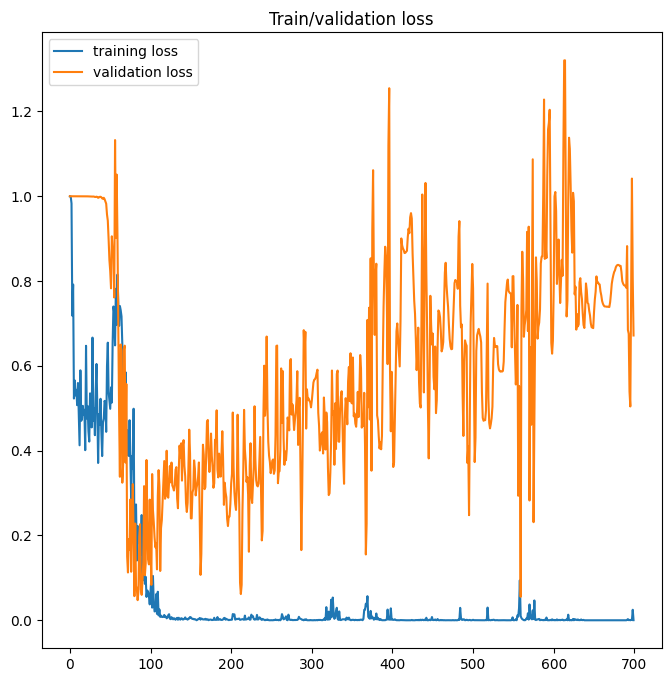

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.title('Train/validation loss')
plt.show()

**Results**

In [ ]:
#test accuracy of embeddings
weighted_model = create_base_model(input_shape,embedding_size)

untrained_results = weighted_model.predict(x_test)
untrained = weighted_model.predict(x_train)

#Get trained weights
for layer_target, layer_source in zip(weighted_model.layers, triplet_model.layers[2].layers):
  weights = layer_source.get_weights()
  layer_target.set_weights(weights)
  del weights

# results = triplet_model.predict(test_dataset)

20/20 [==============================] - 0s 6ms/step


Scatter plot embedding visualization

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
step = 1

x_embeddings = weighted_model.predict(x_train)
test_class_labels = np.unique(np.array(y_train))

decomposed_embeddings = pca.fit_transform(x_embeddings)
decomposed_untrained = pca.fit_transform(untrained)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels[10:30]:
    decomposed_embeddings_class = decomposed_embeddings[y_train == label]
    decomposed_untrained_class = decomposed_untrained[y_train == label]

    plt.subplot(1,2,1)
    plt.scatter(decomposed_untrained_class[::step,1], decomposed_untrained_class[::step,0], label=str(label))
    plt.title('before training (embeddings)')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class[::step, 1], decomposed_embeddings_class[::step, 0], label=str(label))
    plt.title('after @%d epochs' % epochs)
    plt.legend()

plt.show()

20/20 [==============================] - 0s 2ms/step


<Figure size 1600x800 with 0 Axes>

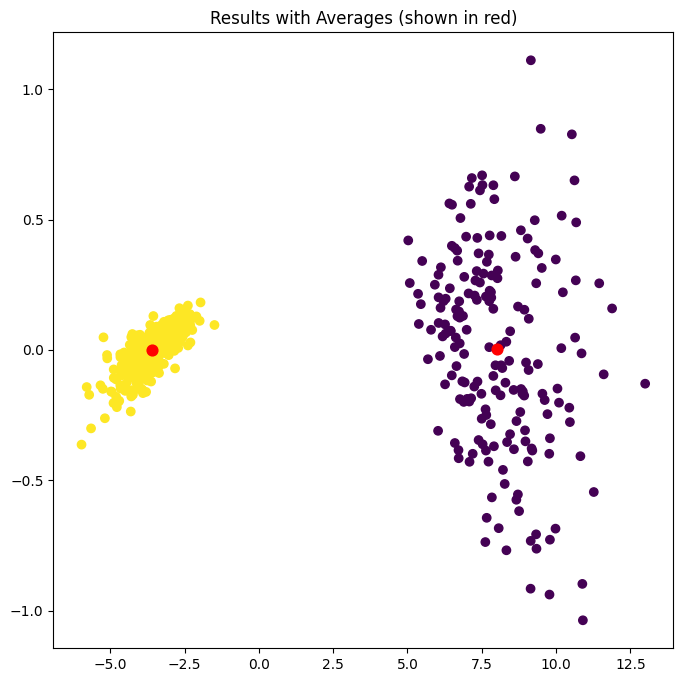

In [ ]:
# Make a dictionary organizing each class w/ the AVG 128-d encoding
name_dict = {}
for i in test_class_labels:
    enc_list = x_embeddings[y_train == i]
    enc = np.zeros((1,128))
    for j in enc_list:
        enc += j

    enc = enc/len(enc_list)
    name_dict[i] = enc

# Display the Averages as Red dots
pca = PCA(n_components=2)
pred_pca = pca.fit_transform(x_embeddings)
fig = plt.figure(figsize=(8, 8))
plt.scatter(pred_pca[:,0], pred_pca[:,1], c=y_train)

for val in name_dict.values():
  point = pca.transform(val)
  plt.scatter(point[0,0], point[0,1], s = [60], c='red')
  plt.title("Results with Averages (shown in red)")
plt.show()



**Testing if it Works!**

1/1 [==============================] - 0s 176ms/step
Predicted Name: George W Bush (Distance = 0.424574)
Actual Name: George W Bush


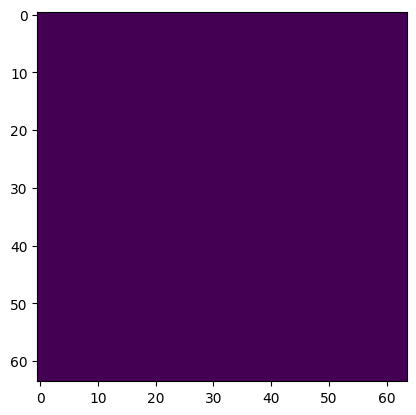

In [ ]:
# Function for encoding a single image
def encode_image(w_model ,img):
  encode = w_model.predict(img.reshape((1,)+ img.shape))
  return encode

# Function for finding the distance between two encoded images
def enc_distance(img1_enc, img2_enc):
  return np.linalg.norm(img2_enc - img1_enc)

def predict_image(w_model, img, dictionary):
    enc = encode_image(w_model, img)
    min_dist = 10000000   # temp value
    main_id = None
    for name in dictionary:
        dist = enc_distance(dictionary[name], enc)
        if min_dist > dist:
            min_dist = dist
            min_id = name

    return min_id, min_dist

idx = 31
img = x_train[idx]

n, d = predict_image(weighted_model, img, name_dict)
print("Predicted Name: %s"%faces.target_names[n] ,"(Distance = %f)"%d)
print("Actual Name: %s"%faces.target_names[y_train[idx]])

img = (np.squeeze(img+training_mean)*255).astype('uint8')
plt.imshow(img)
plt.show()

In [ ]:
# K-neighbor classifier
from sklearn.neighbors import KNeighborsClassifier

KNC = KNeighborsClassifier(n_neighbors=7)
KNC.fit(x_embeddings, y_train)

KNeighborsClassifier(n_neighbors=7)

1/1 [==============================] - 0s 28ms/step
Predicted Name: Colin Powell
Actual Name: Colin Powell


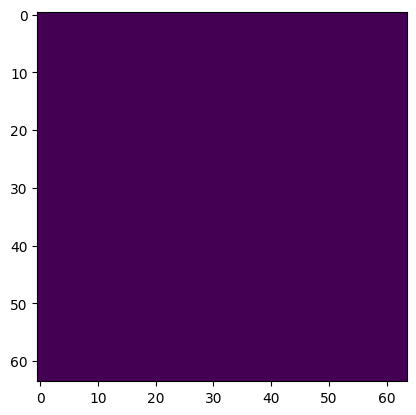

In [ ]:
idx = 7
img = x_test[idx]

enc = encode_image(weighted_model, img)
prediction = KNC.predict(enc)[0]
print("Predicted Name: %s"%faces.target_names[prediction])
print("Actual Name: %s"%faces.target_names[y_test[idx]])

img = (np.squeeze(img+training_mean)*255).astype('uint8')
plt.imshow(img)
plt.show()

**Testing Accuracy**

In [ ]:
enc_x_test = weighted_model.predict(x_test)
pred = KNC.predict(enc_x_test)

print(np.sum(pred == y_test)/len(pred))

3/3 [==============================] - 0s 4ms/step
0.961038961038961


**Adding Custom Datasets**

In [ ]:
def add_person(name, images):
  enc = np.zeros((128,))
  for img in images:
    enc += encode_image(weighted_model, img)
  enc /= len(images)
  name_dict[len(name_dict)] = enc


In [ ]:
target_names = list(faces.target_names)
# Import custom dataset here (already aligned)
import glob
import cv2
filepath = "/content/gdrive/MyDrive/Colab Notebooks/files/face_images/*.png"
my_images = [cv.imread(file) for file in glob.glob(filepath)]
my_images = np.asarray(my_images,dtype='float32')/255
for img in my_images:
  img = cv.resize(img,(64,64))
my_images = np.reshape(my_images,(-1,64,64,1))

# Add custom dataset to embedding dictionary
def add_person(name, images):
    enc = np.zeros((128,))
    for img in images:
        enc += encode_image(weighted_model, img)
    if np.all(enc == 0):
        print(f"Skipping {name} due to invalid encoding")
    else:
        enc /= len(images)
        name_dict[len(name_dict)] = enc


add_person("Nathan Diekema", my_images)



Skipping Nathan Diekema due to invalid encoding


In [ ]:
# Save the entire model to a single HDF5 file
triplet_model.save('/content/drive/My Drive/BTP/full_model.keras')

# Load the entire model from an HDF5 file
# loaded_model = keras.models.load_model("full_model.hdf5")


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=3b98f8aa35391b45864c3128e4b9ea0efa773884f1639cf8f8c521f2eb573de5
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from skimage.io import imread
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.datasets import fetch_lfw_people

# Load your Keras model
model = load_model('/content/drive/My Drive/BTP/softmax_model.hdf5')

# Define a function to preprocess the image for your model
def preprocess_image(image):
    # Resize, normalize, and preprocess the image as needed
    # Example:
    # image = resize_and_normalize(image)
    return image

# Load the LFW dataset
lfw_dataset = fetch_lfw_people(min_faces_per_person=20, resize=0.4)

# Get the data and target (labels)
X, y = lfw_dataset.data, lfw_dataset.target

# Choose an image from the LFW dataset for explanation (you can change the index)
image_index = 0  # Adjust this index as needed
selected_image = X[image_index]
selected_image = preprocess_image(selected_image)

# Define a function to predict using your Keras model
def predict_fn(images):
    # Ensure the input has the correct shape expected by your model
    # Example:
    # images = np.expand_dims(images, axis=0)
    # Make predictions using your model
    predictions = model.predict(images)
    return predictions

# Create a LIME explainer for image data
explainer = lime_image.LimeImageExplainer()

# Explain the model's prediction for the selected image
explanation = explainer.explain_instance(selected_image, predict_fn, top_labels=1, num_samples=1000)

# Create a pipeline to standardize the image data for LIME
pipeline = make_pipeline(StandardScaler())

# Get the explanation image and mask
explanation_image, explanation_mask = explanation.get_image_and_mask(
    explanation.top_labels[0], positive_only=False, hide_rest=False
)

# Apply the mask to the original image and visualize the results
segmented_image = mark_boundaries(explanation_image / 2 + 0.5, explanation_mask)

# Display the original image, explanation image, and segmented image
plt.subplot(1, 3, 1)
plt.imshow(selected_image.reshape(lfw_dataset.images.shape[1:]), cmap=plt.cm.gray)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(explanation_image)
plt.title("Explanation Image")

plt.subplot(1, 3, 3)
plt.imshow(segmented_image)
plt.title("Segmented Image")

plt.show()


ValueError: ignored